# Predictive Election NN Model

Using the cleaned registration and election result data, built a neural network model for predicting outcomes of elections. Input features are:

* Partisan registration in upcoming election
* Partisan registration in prior election
* Outcome of prior election

One of the challenges with predicting election outcomes in Colorado is the variability due to about a third of the state being unaffiliated with the two major parties. The behavior of those unaffiliateds with vary by district, so we need a model that can account for that.

We have a pretty limited dataset, using the following combinations

| Inputs | Output |
|---------|----------|
|2012 reg., results, 2016 reg. | 2016 results |
|2014 reg., results, 2018 reg. | 2018 results |
|2016 reg., results, 2020 reg. | 2020 results |

with the final goal of using the 2016 reg. and results + the most current 2020 reg. to predict the 2020 results.

In [1]:
# Useful imports
import pandas as pd

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow import keras

from matplotlib import pyplot as plt

import numpy as np

from tqdm.notebook import tqdm

%matplotlib inline

res_dir = '../data/results/cleaned'
reg_dir = '../data/registration/cleaned'

build_models = False

## Data Preparation

Need to arrange the cleaned CSV files into the inputs and outputs with appropriate groupings.

Senate elections are every four years, so prior results from 2012 will be paired with registration in 2016 to predict the 2016 outcome. Similarly with 2014 and 2018.

First, define some helper functions that will pre-process the data from the cleaned registration and results files

In [2]:
def get_registration(year):
    """Given an input year, snag the registration data for that year and collapse the affiliation of active
    voters into REP, DEM, OTHER
    
    Returns a dataframe with columns DISTRICT-COUNTY, REP, DEM, OTHERS"""
    
    # read in the data
    reg_df = pd.read_csv(reg_dir+'/{}.csv'.format(year))
    
    # filter out where the county value is empty, which is a "total" row
    reg_df = reg_df[reg_df['COUNTY'].notnull()]
    
    # isolate only active voters
    active_cols = [col for col in reg_df.columns if '-ACTIVE' in col]
    
    # find third-party/unaffiliated voter data
    other_cols = [col for col in active_cols if 'DEM' not in col and 'REP' not in col]
    
    # combine all unaffiliateds into one column
    reg_df['OTHER-ACTIVE'] = reg_df[other_cols].sum(axis=1)
    
    # combine the district and county labels into one
    reg_df['DIST_COUNTY'] = reg_df['DISTRICT'].astype(str) +'-'+ reg_df['COUNTY'].astype(str)

    # pick off only the interesting data
    relabel_dict = {
        'REP-ACTIVE' : 'REP',
        'DEM-ACTIVE' : 'DEM',
        'OTHER-ACTIVE' : 'OTHER'
    }
    new_df = reg_df[['DIST_COUNTY', 'REP-ACTIVE', 'DEM-ACTIVE', 'OTHER-ACTIVE']].rename(columns=relabel_dict)
    
    return new_df
    
def get_results(year):
    """Given an input year, snag the results data for that year and collapse the affiliation of active
    candidates into REP, DEM, OTHER
    
    Returns a dataframe with columns DISTRICT-COUNTY, REP, DEM, OTHERS"""

    # read in the results file
    df = pd.read_csv(res_dir+'/{}.csv'.format(year))
    
    # create a DIST-COUNTY label
    df['DIST_COUNTY'] = df['DISTRICT'].astype(str) + '-' + df['COUNTY'].astype(str)
    
    # isolate third party candidates
    parties = ['DEMOCRATIC PARTY', 'REPUBLICAN PARTY']
    df['PARTY'][~df['PARTY'].isin(parties)] = 'OTHER'
    df['PARTY'][df['PARTY'] == 'REPUBLICAN PARTY'] = 'REP'
    df['PARTY'][df['PARTY'] == 'DEMOCRATIC PARTY'] = 'DEM'

    # sum over precincts, if precincts exist
    agg_cols = {'YES VOTES' : 'sum'}
    df = df.groupby([df['DIST_COUNTY'], df['PARTY']], as_index=False).aggregate(agg_cols)
    
    # Make party votes into columns for each DIST_COUNTY
    df = df.pivot(index='DIST_COUNTY', columns='PARTY', values='YES VOTES').fillna(0)
    df.reset_index(level=0, inplace=True)

    return df

At this point, it is helpful to combine the all the relevant input and output data for each dist-county into a single input and output dataframe.

In [3]:
# Will store the district-county data using the standard key format 
# 'SD [NUMBER]-[COUNTY]' for the Year of the Predicted Results
year_pairs = [['2012', '2016'], ['2014', '2018']]

X_set = np.array([], dtype=np.float64).reshape(0,9)
Y_set = np.array([], dtype=np.float64).reshape(0,3)

for pair in year_pairs:
    
    # The output variables
    current_result = get_results(pair[1])
    elections = current_result.DIST_COUNTY.unique()
    
    # The input variables
    
    # current registration
    current_reg = get_registration(pair[1])
    current_reg = current_reg[current_reg['DIST_COUNTY'].isin(elections)]
    
    # prior election registration
    past_reg = get_registration(pair[0])
    past_reg = past_reg[past_reg['DIST_COUNTY'].isin(elections)]
    
    # prior election result registration
    past_result = get_results(pair[0])
    past_result = past_result[past_result['DIST_COUNTY'].isin(elections)]
    
    # compute fractional current registration
    tot_regs = current_reg.sum(axis=1).values
    dem_regs = current_reg.DEM.values
    rep_regs = current_reg.REP.values
    other_regs = current_reg.OTHER.values

    reg_frac_curr_d = dem_regs/tot_regs
    reg_frac_curr_r = rep_regs/tot_regs
    reg_frac_curr_o = other_regs/tot_regs

    # compute fractional past registration
    tot_regs = past_reg.sum(axis=1).values
    dem_regs = past_reg.DEM.values
    rep_regs = past_reg.REP.values
    other_regs = past_reg.OTHER.values

    reg_frac_past_d = dem_regs/tot_regs
    reg_frac_past_r = rep_regs/tot_regs
    reg_frac_past_o = other_regs/tot_regs
    
    # compute fractional past votes
    dem_votes = past_result.DEM.values
    rep_votes = past_result.REP.values
    other_votes = past_result.OTHER.values
    tot_votes = dem_votes + rep_votes + other_votes

    votes_frac_past_d = dem_votes/tot_votes
    votes_frac_past_r = rep_votes/tot_votes
    votes_frac_past_o = other_votes/tot_votes
    
    X = np.array([reg_frac_curr_d, reg_frac_curr_r, reg_frac_curr_o,
               reg_frac_past_d, reg_frac_past_r, reg_frac_past_o,
               votes_frac_past_d, votes_frac_past_r, votes_frac_past_o]).T
    
    # Now for the outputs
    # compute current fractional votes
    dem_votes = current_result.DEM.values
    rep_votes = current_result.REP.values
    other_votes = current_result.OTHER.values
    tot_votes = dem_votes + rep_votes + other_votes
    
    votes_frac_curr_d = dem_votes/tot_votes
    votes_frac_curr_r = rep_votes/tot_votes
    votes_frac_curr_o = other_votes/tot_votes
    
    Y = np.array([votes_frac_curr_d, votes_frac_curr_r, votes_frac_curr_o]).T
    
    X_set = np.vstack([X_set, X])
    Y_set = np.vstack([Y_set, Y])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Model Training

### Split the Data

Split into a train-test split to validate the data

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
print(np.shape(X_set))
X_test, X_train, Y_test, Y_train = train_test_split(X_set, Y_set, train_size=.2)
print(np.shape(X_test))

(89, 9)
(17, 9)


### Train a Model

This is a small dataset, so we need to use a very shallow neural network

In [6]:
model = Sequential()

model.add(Dense(2,input_dim=9, activation='tanh'))
model.add(Dense(3,activation='sigmoid'))

model.compile(loss='mean_squared_error', optimizer='adam')

In [7]:
hist = model.fit(x=X_train, y=Y_train, 
                    validation_data= (X_test, Y_test),
                     batch_size = 10,
                     shuffle = True,
                     epochs = 1000,
                     verbose = False)

<Figure size 432x288 with 0 Axes>

Text(0.5, 0, 'epoch')

Text(0, 0.5, 'validation loss')

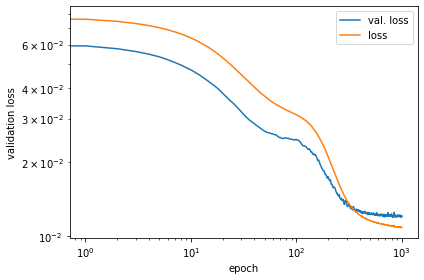

In [8]:
plt.figure()
plt.loglog(hist.epoch, hist.history['val_loss'], label = 'val. loss')
plt.loglog(hist.epoch, hist.history['loss'], label = 'loss')
plt.xlabel('epoch')
plt.ylabel('validation loss')
plt.legend()
plt.tight_layout()
plt.savefig('election_model.png')

### Train an ensemble of models

Because of the small number of data points, uncertainty quantification is important. So, build an ensemble of models from different training data, and then make the predictions using the average/spread of each model.

For a 20% train-test split, there are $\binom{89}{71} \approx 3 \times 10^{18}$ possible combinations. So, we aren't too worried about repeats.

In [9]:
if build_models:
    n_models = 1000
    train_size = .2
    models_dict = {}

    losses = []
    vals = []

    for model_num in tqdm(range(n_models)):

        X_test, X_train, Y_test, Y_train = train_test_split(X_set, Y_set, train_size=train_size)
        model = Sequential()

        model.add(Dense(2,input_dim=9, activation='tanh'))
        model.add(Dense(3,activation='sigmoid'))

        model.compile(loss='mean_squared_error', optimizer='adam')

        hist = model.fit(x=X_train, y=Y_train, 
                        validation_data= (X_test, Y_test),
                         batch_size = 20,
                         shuffle = True,
                         epochs = 1000,
                         verbose = False)

        models_dict['model {}'.format(model_num)] = model
        losses.append(hist.history['loss'][-1])
        vals.append(hist.history['val_loss'][-1])

    #    print('final loss = {}'.format(hist.history['loss'][-1]))
    #    print('final val. loss = {}\n'.format(hist.history['val_loss'][-1]))
    for model in models_dict:
    
        models_dict[model].save('./model/{}'.format(model))

## 2020 Predictions

In [10]:
pair = ['2016', '2020']

# The input variables

# prior election result registration
past_result = get_results(pair[0])
elections = past_result.DIST_COUNTY.unique()
past_result = past_result[past_result['DIST_COUNTY'].isin(elections)]

# current registration
current_reg = get_registration(pair[1])
current_reg = current_reg[current_reg['DIST_COUNTY'].isin(elections)]

# prior election registration
past_reg = get_registration(pair[0])
past_reg = past_reg[past_reg['DIST_COUNTY'].isin(elections)]

# compute fractional current registration
tot_regs = current_reg.sum(axis=1).values
dem_regs = current_reg.DEM.values
rep_regs = current_reg.REP.values
other_regs = current_reg.OTHER.values

reg_frac_curr_d = dem_regs/tot_regs
reg_frac_curr_r = rep_regs/tot_regs
reg_frac_curr_o = other_regs/tot_regs

# compute fractional past registration
tot_regs = past_reg.sum(axis=1).values
dem_regs = past_reg.DEM.values
rep_regs = past_reg.REP.values
other_regs = past_reg.OTHER.values

reg_frac_past_d = dem_regs/tot_regs
reg_frac_past_r = rep_regs/tot_regs
reg_frac_past_o = other_regs/tot_regs

# compute fractional past votes
dem_votes = past_result.DEM.values
rep_votes = past_result.REP.values
other_votes = past_result.OTHER.values
tot_votes = dem_votes + rep_votes + other_votes

votes_frac_past_d = dem_votes/tot_votes
votes_frac_past_r = rep_votes/tot_votes
votes_frac_past_o = other_votes/tot_votes

X_pred = np.array([reg_frac_curr_d, reg_frac_curr_r, reg_frac_curr_o,
           reg_frac_past_d, reg_frac_past_r, reg_frac_past_o,
           votes_frac_past_d, votes_frac_past_r, votes_frac_past_o]).T

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [17]:
Y_pred = model.predict(X_pred)
votes = np.reshape(tot_regs,(len(tot_regs),1)) * Y_pred
print(votes)

[[4.27897817e+04 6.43810069e+04 1.44743396e+03]
 [8.64043916e+03 2.20236006e+04 3.18967742e+02]
 [7.52072366e+03 2.61860903e+03 2.72034394e+02]
 [8.68211096e+02 1.01582698e+02 4.28532168e+01]
 [6.33263820e+03 9.36741197e+02 2.86147057e+02]
 [2.14701280e+03 1.57772619e+03 7.02254937e+01]
 [1.47027466e+04 1.78069867e+03 7.29597198e+02]
 [1.17514423e+04 7.64472076e+03 3.92477703e+02]
 [3.61895570e+04 5.46396455e+04 1.22559284e+03]
 [3.32762294e+04 4.77501306e+04 1.12129101e+03]
 [5.21111509e+04 5.12039249e+04 1.72597885e+03]
 [5.23726978e+04 4.25479683e+04 1.74419261e+03]
 [4.26301400e+04 6.06142012e+04 1.46942774e+03]
 [5.95525432e+04 3.55982379e+04 2.00383417e+03]
 [3.76895337e+04 3.15848041e+04 1.25498764e+03]
 [3.07063067e+04 1.09911180e+04 1.11193253e+03]
 [1.09824145e+04 2.43115355e+03 4.41063491e+02]
 [5.06234157e+04 7.61730787e+03 2.29310846e+03]
 [3.07927319e+04 4.28484186e+04 1.04170238e+03]
 [2.74888239e+04 6.63545730e+04 1.01065154e+03]
 [3.35260356e+04 6.30691933e+04 1.176142

Iterate over all models, get the predicted vote totals by district-county for each model, and store. We will eventually compute total and spread of votes in each district

In [62]:
import glob

models = glob.glob('./model/*')

tot_regs = current_reg.sum(axis=1).values
print(current_reg.sum(axis=1))
tot_regs = np.reshape(tot_regs, (len(tot_regs),1))

preds_array = []

for model in tqdm(models):
    this_model = keras.models.load_model(model)
    preds = this_model.predict(X_pred)
    preds_array.append(preds*tot_regs)

17    127697.0
34     33797.0
35     10776.0
36       965.0
37      7879.0
38      4008.0
39     17656.0
40     19806.0
42     96079.0
44     89192.0
46    105276.0
52    105983.0
53    100688.0
54    103041.0
56     81057.0
58     47952.0
59     17418.0
60     73981.0
62     86092.0
63     98456.0
64    101577.0
65     94460.0
66     83083.0
68      4498.0
69    103274.0
71    103783.0
73      8816.0
74      2561.0
75      2564.0
76      4927.0
77      2472.0
78      2007.0
79      3756.0
80      4763.0
81       966.0
82      9077.0
83       766.0
84     11183.0
85      6371.0
86     12813.0
87      6905.0
88      3879.0
dtype: float64


SystemError: <built-in function CreateBufferedInputStream> returned a result with an error set

In [35]:
mean_df = pd.DataFrame(data = {'DIST_COUNTY' : elections,
                              'DEM' : np.mean(preds_array, axis=0)[:,0],
                              'REP' : np.mean(preds_array, axis=0)[:,1],
                              'OTHER' : np.mean(preds_array, axis=0)[:,2]})

std_df = pd.DataFrame(data = {'DIST_COUNTY' : elections,
                              'DEM' : np.std(preds_array, axis=0)[:,0],
                              'REP' : np.std(preds_array, axis=0)[:,1],
                              'OTHER' : np.std(preds_array, axis=0)[:,2]})

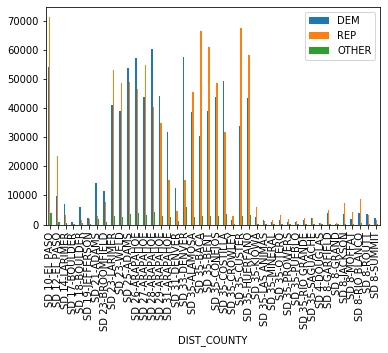

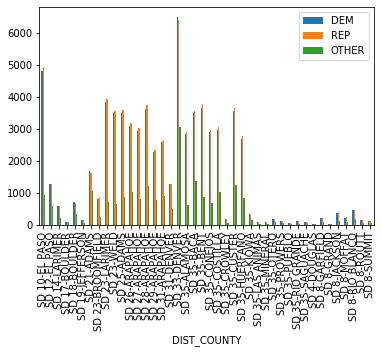

In [36]:
mean_df.plot.bar(x='DIST_COUNTY')
std_df.plot.bar(x='DIST_COUNTY')

In [39]:
mean_df['DISTRICT'] = mean_df['DIST_COUNTY'].str.split('-').str[0]
std_df['DISTRICT'] = std_df['DIST_COUNTY'].str.split('-').str[0]

mean_df['COUNTY'] = mean_df['DIST_COUNTY'].str.split('-').str[1]
std_df['COUNTY'] = std_df['DIST_COUNTY'].str.split('-').str[1]

print(mean_df)
print(std_df)

         DIST_COUNTY           DEM           REP        OTHER DISTRICT  \
0      SD 10-EL PASO  53948.811127  71056.599543  3848.602411    SD 10   
1      SD 12-EL PASO   9836.861627  23422.638506   992.568532    SD 12   
2      SD 14-LARIMER   7118.142703   3420.805023   546.747529    SD 14   
3      SD 17-BOULDER    783.948084    166.784859   102.529167    SD 17   
4      SD 18-BOULDER   6121.913801   1623.704817   644.333684    SD 18   
5    SD 19-JEFFERSON   2135.935959   1780.869220   160.555060    SD 19   
6        SD 21-ADAMS  14370.943306   3020.870442  1748.411738    SD 21   
7   SD 23-BROOMFIELD  11582.626346   7761.540859   793.556056    SD 23   
8      SD 23-LARIMER  40911.369497  53130.806835  2878.951770    SD 23   
9         SD 23-WELD  38866.528654  48408.885837  2707.950727    SD 23   
10       SD 25-ADAMS  53817.180234  49028.468848  3629.470892    SD 25   
11    SD 26-ARAPAHOE  57070.404855  46436.356524  3918.801718    SD 26   
12    SD 27-ARAPAHOE  43701.118365  54

### Election Predictions

Here are the total vote predictions for each district

Text(0.5, 1.0, 'District SD 10 Predictions')

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

[Text(0, 0, 'EL PASO'), Text(0, 0, 'TOTAL')]

Text(0, 3, '53,948')

Text(0, 3, '71,056')

Text(0, 3, '3,848')

Text(0.5, 1.0, 'District SD 12 Predictions')

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

[Text(0, 0, 'EL PASO'), Text(0, 0, 'TOTAL')]

Text(0, 3, '9,836')

Text(0, 3, '23,422')

Text(0, 3, '992')

Text(0.5, 1.0, 'District SD 14 Predictions')

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

[Text(0, 0, 'LARIMER'), Text(0, 0, 'TOTAL')]

Text(0, 3, '7,118')

Text(0, 3, '3,420')

Text(0, 3, '546')

Text(0.5, 1.0, 'District SD 17 Predictions')

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

[Text(0, 0, 'BOULDER'), Text(0, 0, 'TOTAL')]

Text(0, 3, '783')

Text(0, 3, '166')

Text(0, 3, '102')

Text(0.5, 1.0, 'District SD 18 Predictions')

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

[Text(0, 0, 'BOULDER'), Text(0, 0, 'TOTAL')]

Text(0, 3, '6,121')

Text(0, 3, '1,623')

Text(0, 3, '644')

Text(0.5, 1.0, 'District SD 19 Predictions')

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

[Text(0, 0, 'JEFFERSON'), Text(0, 0, 'TOTAL')]

Text(0, 3, '2,135')

Text(0, 3, '1,780')

Text(0, 3, '160')

Text(0.5, 1.0, 'District SD 21 Predictions')

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

[Text(0, 0, 'ADAMS'), Text(0, 0, 'TOTAL')]

Text(0, 3, '14,370')

Text(0, 3, '3,020')

Text(0, 3, '1,748')

Text(0.5, 1.0, 'District SD 23 Predictions')

<BarContainer object of 4 artists>

<BarContainer object of 4 artists>

<BarContainer object of 4 artists>

[Text(0, 0, 'BROOMFIELD'),
 Text(0, 0, 'LARIMER'),
 Text(0, 0, 'WELD'),
 Text(0, 0, 'TOTAL')]

Text(0, 3, '91,360')

Text(0, 3, '109,301')

Text(0, 3, '6,380')

Text(0.5, 1.0, 'District SD 25 Predictions')

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

[Text(0, 0, 'ADAMS'), Text(0, 0, 'TOTAL')]

Text(0, 3, '53,817')

Text(0, 3, '49,028')

Text(0, 3, '3,629')

Text(0.5, 1.0, 'District SD 26 Predictions')

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

[Text(0, 0, 'ARAPAHOE'), Text(0, 0, 'TOTAL')]

Text(0, 3, '57,070')

Text(0, 3, '46,436')

Text(0, 3, '3,918')

Text(0.5, 1.0, 'District SD 27 Predictions')

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

[Text(0, 0, 'ARAPAHOE'), Text(0, 0, 'TOTAL')]

Text(0, 3, '43,701')

Text(0, 3, '54,797')

Text(0, 3, '3,122')

Text(0.5, 1.0, 'District SD 28 Predictions')

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

[Text(0, 0, 'ARAPAHOE'), Text(0, 0, 'TOTAL')]

Text(0, 3, '60,390')

Text(0, 3, '40,251')

Text(0, 3, '4,234')

Text(0.5, 1.0, 'District SD 29 Predictions')

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

[Text(0, 0, 'ARAPAHOE'), Text(0, 0, 'TOTAL')]

Text(0, 3, '44,181')

Text(0, 3, '34,970')

Text(0, 3, '3,052')

Text(0.5, 1.0, 'District SD 31 Predictions')

<BarContainer object of 3 artists>

<BarContainer object of 3 artists>

<BarContainer object of 3 artists>

[Text(0, 0, 'ARAPAHOE'), Text(0, 0, 'DENVER'), Text(0, 0, 'TOTAL')]

Text(0, 3, '44,375')

Text(0, 3, '19,590')

Text(0, 3, '3,533')

Text(0.5, 1.0, 'District SD 33 Predictions')

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

[Text(0, 0, 'DENVER'), Text(0, 0, 'TOTAL')]

Text(0, 3, '57,566')

Text(0, 3, '15,153')

Text(0, 3, '5,959')

Text(0.5, 1.0, 'District SD 35 Predictions')

<BarContainer object of 17 artists>

<BarContainer object of 17 artists>

<BarContainer object of 17 artists>

[Text(0, 0, 'ALAMOSA'),
 Text(0, 0, 'BACA'),
 Text(0, 0, 'BENT'),
 Text(0, 0, 'CONEJOS'),
 Text(0, 0, 'COSTILLA'),
 Text(0, 0, 'CROWLEY'),
 Text(0, 0, 'CUSTER'),
 Text(0, 0, 'HUERFANO'),
 Text(0, 0, 'KIOWA'),
 Text(0, 0, 'LAS ANIMAS'),
 Text(0, 0, 'MINERAL'),
 Text(0, 0, 'OTERO'),
 Text(0, 0, 'PROWERS'),
 Text(0, 0, 'PUEBLO'),
 Text(0, 0, 'RIO GRANDE'),
 Text(0, 0, 'SAGUACHE'),
 Text(0, 0, 'TOTAL')]

Text(0, 3, '291,293')

Text(0, 3, '401,413')

Text(0, 3, '22,091')

Text(0.5, 1.0, 'District SD 4 Predictions')

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

[Text(0, 0, 'DOUGLAS'), Text(0, 0, 'TOTAL')]

Text(0, 3, '371')

Text(0, 3, '575')

Text(0, 3, '29')

Text(0.5, 1.0, 'District SD 8 Predictions')

<BarContainer object of 8 artists>

<BarContainer object of 8 artists>

<BarContainer object of 8 artists>

[Text(0, 0, 'GARFIELD'),
 Text(0, 0, 'GRAND'),
 Text(0, 0, 'JACKSON'),
 Text(0, 0, 'MOFFAT'),
 Text(0, 0, 'RIO BLANCO'),
 Text(0, 0, 'ROUTT'),
 Text(0, 0, 'SUMMIT'),
 Text(0, 0, 'TOTAL')]

Text(0, 3, '19,577')

Text(0, 3, '30,432')

Text(0, 3, '1,588')

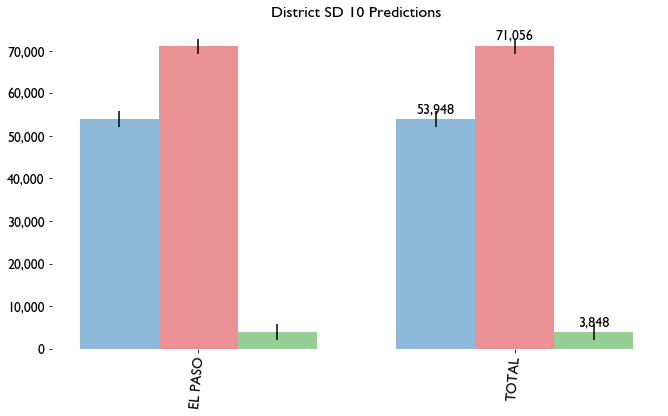

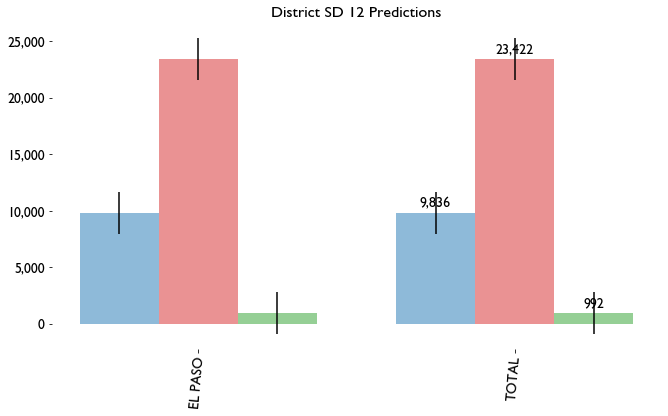

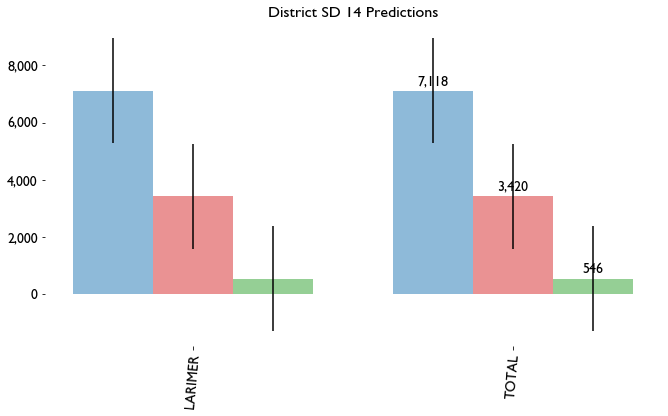

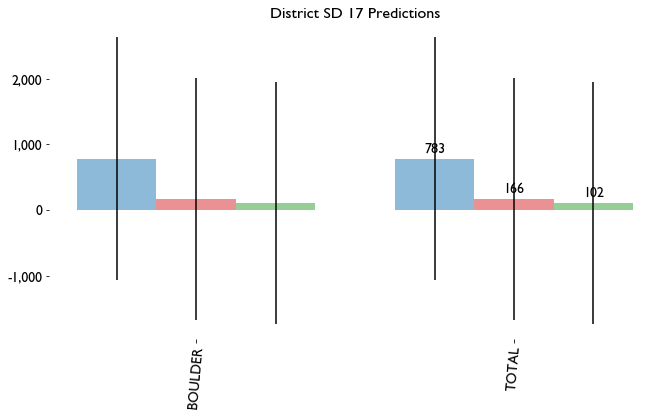

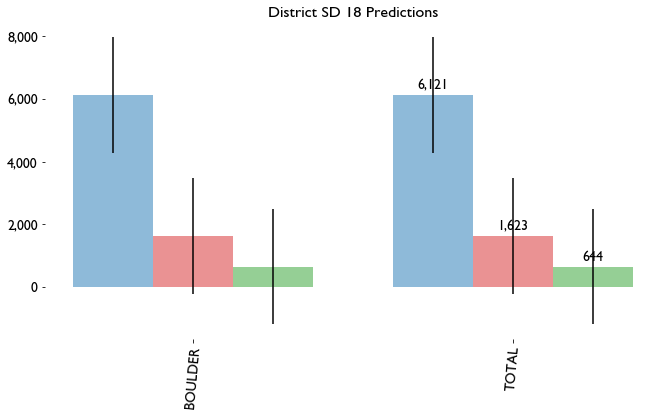

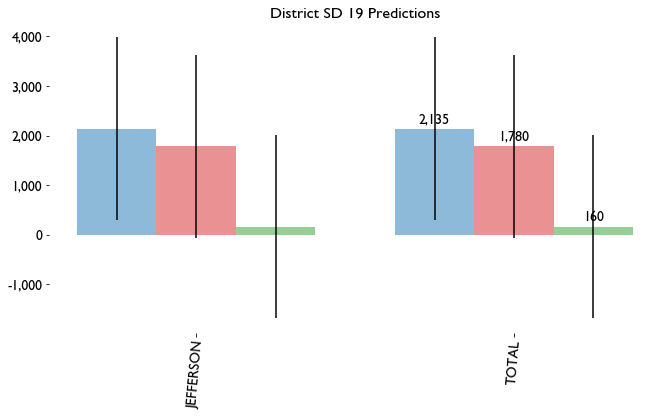

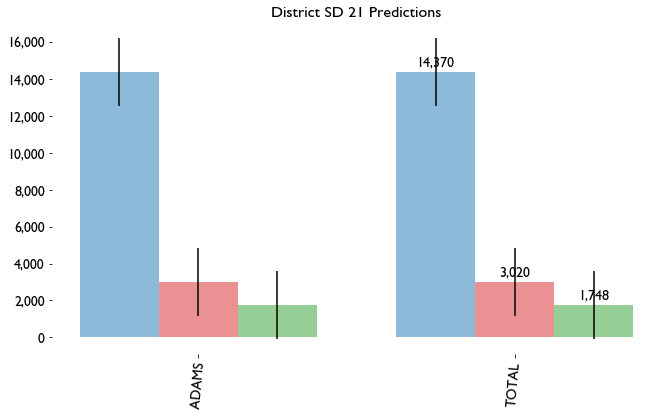

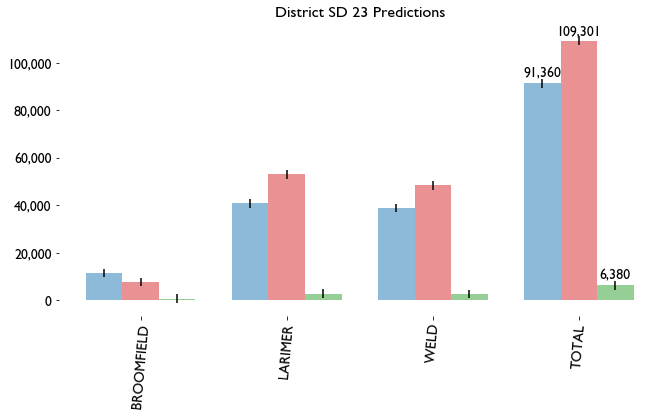

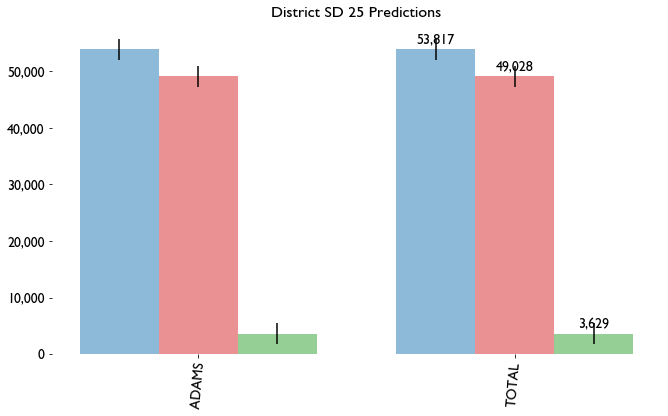

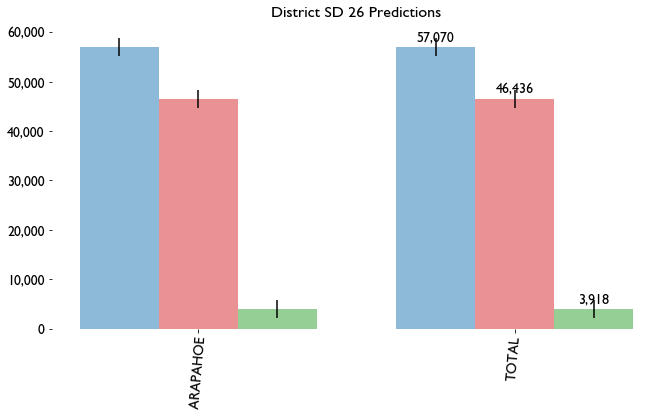

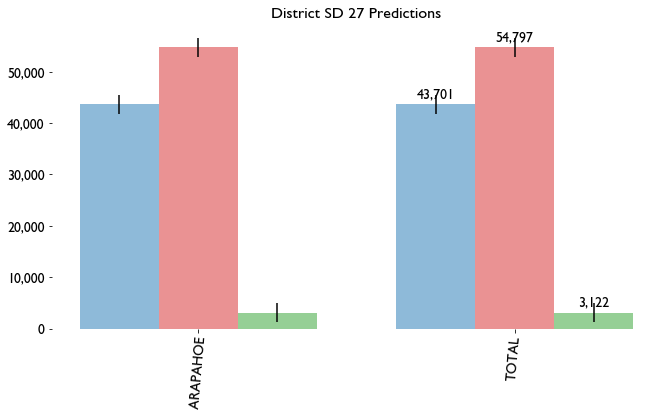

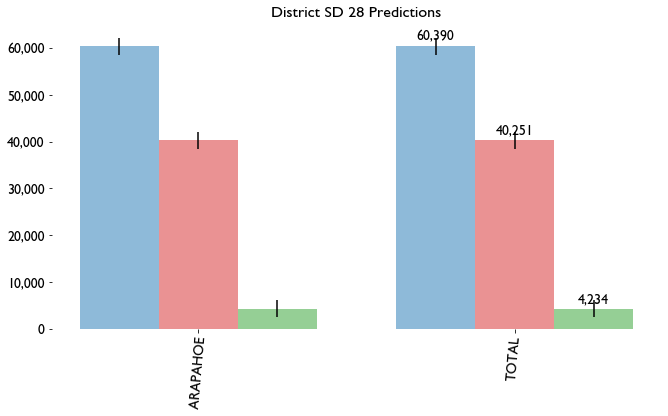

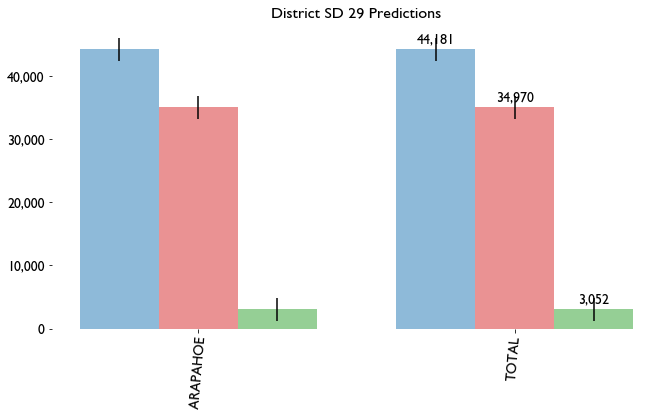

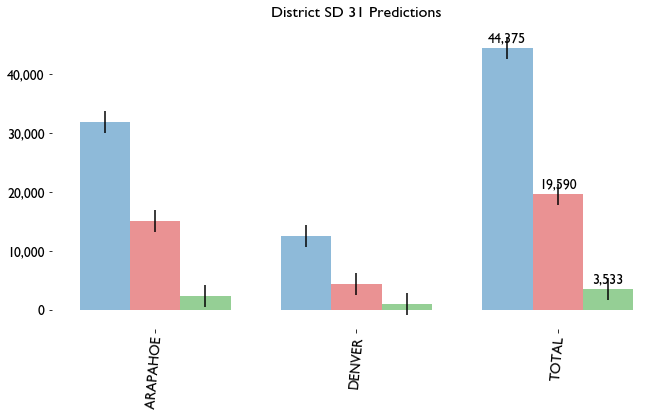

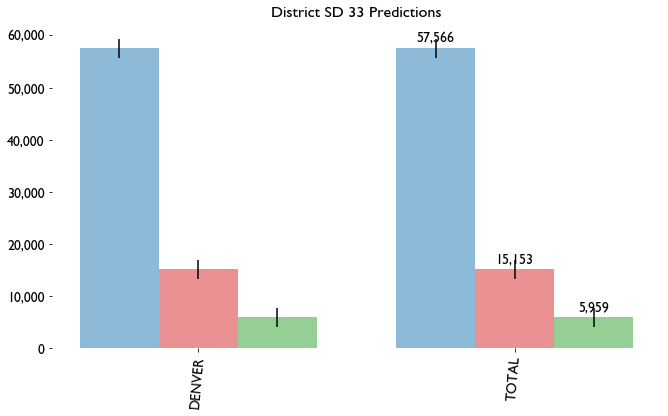

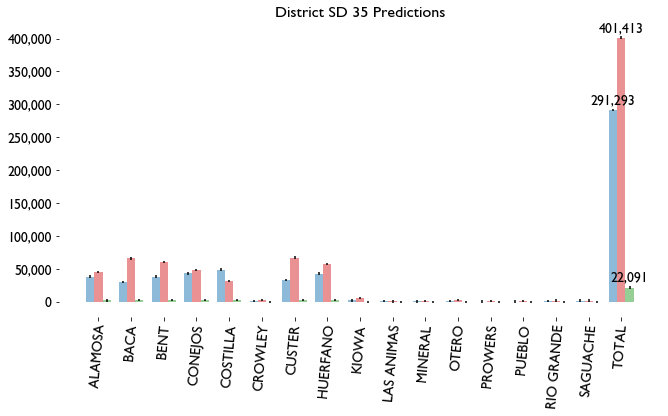

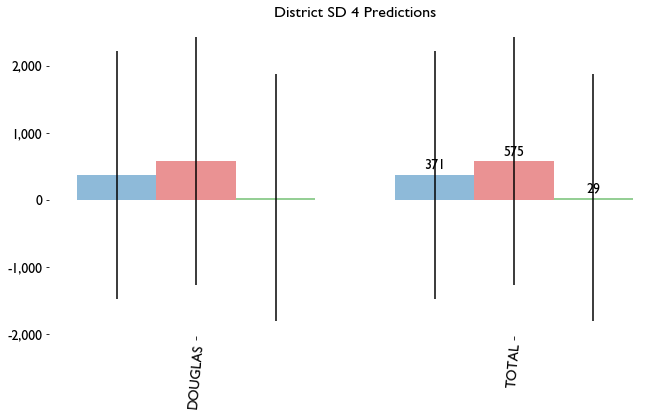

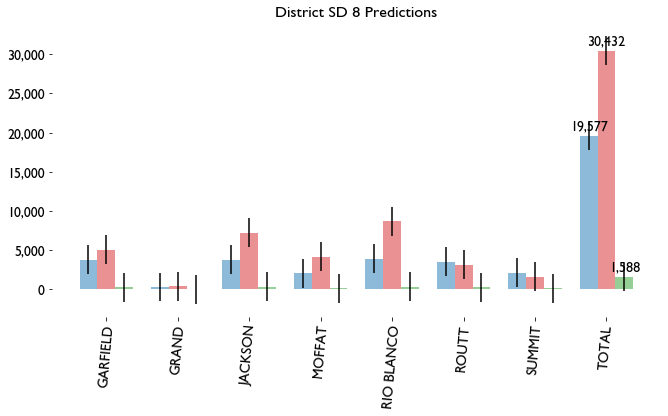

In [61]:
import matplotlib as mpl

# Use the Gill Sans font
import matplotlib.pylab as pylab

import matplotlib.font_manager as fm
font = fm.FontProperties(
       family = 'Gill Sans',
       fname = '/usr/share/fonts/truetype/adf/GilliusADF-Regular.otf')
params = {
         'font.size': 14,
         'font.style': 'italic',
         'legend.fontsize': 14,
         'figure.figsize': (9.5, 6),
         'axes.labelsize': 14,
         'axes.titlesize': 16,
         'xtick.labelsize': 14,
         'ytick.labelsize': 14,
         'axes.spines.right' : False,
         'axes.spines.left' : False,
         'axes.spines.top' : False,
         'axes.spines.bottom' : False,
         'font.family' : 'Gill Sans'}
pylab.rcParams.update(params)


width = .25

for district in mean_df.DISTRICT.unique():
    fig, ax = plt.subplots()
    
    ax.set_title('District {} Predictions'.format(district));
    
    counties = mean_df[mean_df.DISTRICT == district].COUNTY.values
    
    dem_votes   = mean_df[mean_df.DISTRICT == district].DEM.values
    rep_votes   = mean_df[mean_df.DISTRICT == district].REP.values
    other_votes = mean_df[mean_df.DISTRICT == district].OTHER.values
    
    dem_std   = std_df[mean_df.DISTRICT == district].DEM.values
    rep_std   = std_df[mean_df.DISTRICT == district].REP.values
    other_std = std_df[mean_df.DISTRICT == district].OTHER.values
    
    counties = np.append(counties, 'TOTAL')
    
    dem_votes = np.append(dem_votes, np.sum(dem_votes))
    dem_std = np.append(dem_std, np.sum(dem_std))
    
    rep_votes = np.append(rep_votes, np.sum(rep_votes))
    rep_std = np.append(rep_std, np.sum(rep_std))
    
    other_votes = np.append(other_votes, np.sum(other_votes))
    other_std = np.append(other_std, np.sum(other_std))
    
    
    x = np.arange(len(counties))
    
    ax.bar(x - width, dem_votes, width, label=counties, yerr=2.*std_other, color='tab:blue', alpha=0.5);
    ax.bar(x, rep_votes, width, label=counties, yerr = 2.*std_other, color='tab:red', alpha=0.5);
    ax.bar(x+width, other_votes, width, label=counties, yerr = 2.*std_other, color='tab:green', alpha=0.5);
    
    ax.set_xticks(x)
    for tick in ax.get_xticklabels():
        tick.set_rotation(85)
    ax.set_xticklabels(counties)
    ax.get_yaxis().set_major_formatter(
        mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    ax.annotate(format(int(dem_votes[-1]), ','),
            xy=(x[-1]-width, dem_votes[-1]),
            xytext=(0, 3),  # 3 points vertical offset
            textcoords="offset points",
            ha='center', va='bottom');
    
    ax.annotate(format(int(rep_votes[-1]), ','),
            xy=(x[-1], rep_votes[-1]),
            xytext=(0, 3),  # 3 points vertical offset
            textcoords="offset points",
            ha='center', va='bottom');
    
    ax.annotate(format(int(other_votes[-1]), ','),
            xy=(x[-1]+width, other_votes[-1]),
            xytext=(0, 3),  # 3 points vertical offset
            textcoords="offset points",
            ha='center', va='bottom');
    
    
    fig.tight_layout()